# Model Training

We use VAE to train our model. We then visualize it on the trained latent space.

In [1]:
#VAE code from PyTorch Tutorial

from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

epochs = 10

parser = argparse.ArgumentParser(description='VAE MNIST Example')


device = torch.device("cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} 
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=512, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=512, shuffle=True, **kwargs)


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 10) # dimension of latent sapce = 10
        self.fc22 = nn.Linear(400, 10)
        self.fc3 = nn.Linear(10, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 10 == 0:
            '''
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

            '''
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    #print('====> Test set loss: {:.4f}'.format(test_loss))

if __name__ == "__main__":
    for epoch in range(1, epochs + 1):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(64, 10).to(device)
            sample = model.decode(sample).cpu()
            #save_image(sample.view(64, 1, 28, 28),'cur_result/sample_' + str(epoch) + '.png')

====> Epoch: 1 Average loss: 220.2009
====> Epoch: 2 Average loss: 147.1938
====> Epoch: 3 Average loss: 132.2933
====> Epoch: 4 Average loss: 126.7244
====> Epoch: 5 Average loss: 123.4601
====> Epoch: 6 Average loss: 121.2616
====> Epoch: 7 Average loss: 119.5985
====> Epoch: 8 Average loss: 118.2818
====> Epoch: 9 Average loss: 117.1858
====> Epoch: 10 Average loss: 116.3297


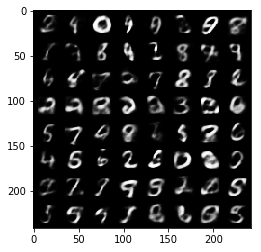

In [5]:
import matplotlib.pyplot as plt
import numpy as np


temp = torch.randn(64, 10).to(device)
temp = model.decode(temp).cpu()

def show(img):
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    plt.show()

with torch.no_grad():
    sample = torch.randn(64, 10).to(device)
    sample = model.decode(sample).cpu()
    plt.figure()
    show(make_grid(sample.view(64, 1, 28, 28)))
    plt.show()

#imgplot = plt.imshow(temp2[:,1])
#print(type(temp2))

# Visualisation of Latent Space

We use the hilbert curve to sample the latent space.

In [6]:
from ipywidgets import interactive
from hilbert import HilbertCurve
import numpy as np

def plotting(p=4, t=0.6):
    N = 10 #define the dimension of embedded space
    #T = t + dt
    hilbert_curve = HilbertCurve(p, N) #initialize hilbert curve
    cur_dist = int(t * (2**(N*p)-1)) #t is in scale [0,1], dist is in scale[0, 2^(Np)-1]
    
    #sample points near cur_dist
    dists = [cur_dist-10, cur_dist-5, cur_dist, cur_dist+5, cur_dist+10] 
    
    
    coords = [hilbert_curve.coordinates_from_distance(dist) for dist in dists]

    norm_coords = np.array([[[((coord_x / (2**(p-1)))-1) for coord_x in coord]]  for coord in coords])
    #convert coords in hyperspace back to scale [-1,1] (the latent space we're exploring)

    b = torch.tensor(norm_coords).type(torch.FloatTensor).to(device)
    sample = model.decode(b).cpu() #decode norm_coords
    #shape(sample)
    show(make_grid(sample.view(5, 1, 28, 28)))
    
    
interactive_plot = interactive(plotting, p = (1,10,1), t=(0,1,0.05))
interactive_plot

interactive(children=(IntSlider(value=4, description='p', max=10, min=1), FloatSlider(value=0.6, description='…